# Research Methodology (Summary)

# Data Importation

In [137]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import antropy as ant
from collections import namedtuple
import pywt
from math import floor
from scipy import stats
import matplotlib.pyplot as plt

In [138]:
# import the data for patient 1
dict_ = loadmat('./Class A train sets/2_EEG200908190811.mat')
dict_.keys()

dict_keys(['__header__', '__version__', '__globals__', 'BIS', 'x', 'CH2', 'Denoised_x', 'CH2Denoised_x'])

<br/>

# Windowing

The workflow in the walkthrough section is used to create the ```generate_samples``` and ```generate_DFTParameters``` functions. Windowing is performed because the complexity features are computed using five-second small windows with 50% overlap.

In [139]:
# Generate the windows
def generate_samples(bis, eeg, window_size=60, sampling_rate=128, verbose=False):
    """
    Generates EEG samples for consecutive windows 
    and their corresponding BIS value
    
    
    Parameters
    ----------       
    eeg: (n,) array. 
        EEG Sample. 
        
    bis: (n,) array
        BIS Sample
        
    window_size: int, default: 5 
        Duration of each window in seconds
        
    sampling_rate: float default: 128
        Sampling rate of the EEG sample in Hz.
        
    
    Generates
    ---------
    tup: tuple(bis_mode, eeg_sample)
    
        bis_mode: float
            Modal BIS value of the EEG Sample
        
        eeg_sample: array
            EEG Sample for a 5 second window
        
        
        
    Example
    -------
    >>> awake = np.array([82.8])
    >>> eeg = array([ 0.17727497,  0.17783894,  0.17834346,  0.17878847,  0.17917353,
        0.17949788,  0.17976084,  0.17996202,  0.18010136,  0.18017881, ...])
       
    >>> # Create the generator
    >>> gen_sample = generate_samples(bis, eeg)
    
    >>> # Generate EEG sample
    >>> sample = next(gen_sample)
    
    
    Notes
    -----
    The function works well with the generate_DFTParameters function.
    
    >>> generate_DFTParameters(sample)
    [0.075986      0.206614     0.405465      1.290984      0.980829       84.5]
    
    """
    
    bis_len = len(bis)
    
    if bis_len < window_size:
        print("Length of BIS values must be greater than {}".format(window_size))
        return    

    
    start, end = 0, window_size
    
    eeg_start, eeg_end = 0, end * sampling_rate
    
    
    while True:
        if end > bis_len:
            break
        
        bis_idx = bis[start:end][-1][0]
        
        eeg_sample = eeg[eeg_start:eeg_end]
        
        data = namedtuple('EEG_Sample', ['eeg', 'bis'])
        
        tup = data(eeg_sample, bis_idx)
        
        if verbose:
            print("EEG Start: {} - {}".format(eeg_start, eeg_end))
        
        yield tup
        
        # update ranges
        start += 1
        end += 1
        
        eeg_start = start * sampling_rate
        eeg_end = end * sampling_rate
        
        


    

<br/>

## Testing <code>generate_samples</code>

We have to make sure that 60th BIS value for this patient - **82.9**, is the first value generated by the generator.

In [140]:
# Get the data
bis = dict_.get('BIS')
eeg_sample = np.ravel(dict_.get('CH2Denoised_x'))

In [141]:
# Create the generator
test_generator = generate_samples(bis, eeg_sample, verbose=True)

test_sample = next(test_generator)

print("First BIS index: ", test_sample.bis)

# Check that BIS values are only recorded after 60 seconds
# The 60th BIS is 82.9 for this patient
assert test_sample.bis == bis[59] == 82.9

EEG Start: 0 - 7680
First BIS index:  82.9


<br/>

# Feature Extraction

## DFT <code>generate_DFTParameters</code>

In [142]:
def generate_DFTParameters(eeg_sample, sampling_rate=128):
    """
    Generate the DFT parameters of EEG segments
    
    
    Parameters
    ----------
    eeg_sample: namedtuple('EEG_Sample', ['eeg', 'bis'])
    
        eeg: (n,) array 
            EEG Data
            
        bis: float
            Bispectral Index
            
        
    sampling_rate: int
        Sampling rate of the EEG segment
        
        
    Returns
    -------
    df : pd.DataFrame
        DataFrame of EEG parameters
        
    
    Notes
    -----
    Works well with the generate_samples function. See the documentation on generate_samples.
    """
    
    # amplitudes
    fft_values = np.absolute(np.fft.rfft(eeg_sample.eeg))

    # frequencies
    fft_freq = np.fft.rfftfreq(len(eeg_sample.eeg), 1.0/sampling_rate)
    
    # Analysing the bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    eeg_band_fft = dict()

    for band in eeg_bands.keys():
        freq_idx = np.where((fft_freq >= eeg_bands[band][0]) & (fft_freq <= eeg_bands[band][1]))

        # sum the amplitudes of the bands
        eeg_band_fft[band] = fft_values[freq_idx]
        
    
    # Sample entropy of the delta band
    sampen_delta = ant.sample_entropy(eeg_band_fft['Delta'])
    sampen_beta = ant.sample_entropy(eeg_band_fft['Beta'])
    sampen_theta = ant.sample_entropy(eeg_band_fft['Theta'])
    sampen_gamma = ant.sample_entropy(eeg_band_fft['Gamma'])
    sampen_alpha = ant.sample_entropy(eeg_band_fft['Alpha'])
    
    
    # produce DataFrame of DFT Parameters
    #  columns=["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"]
    params = [sampen_delta, sampen_beta, sampen_theta, sampen_gamma, sampen_alpha, eeg_sample.bis]
    
    return params
    
    
    

<br/>

## DWT <code>generate_DWTParameters</code>

In [143]:
def generate_DWTParameters(eeg_sample, wavelet="db4"):
    
    """
    Generate the DWT Parameters of an EEG Sample
    
    
    Parameters
    -----------
    eeg_sample: namedtuple('EEG_Sample', ['eeg', 'bis'])
    
        bis: float
            Bispectral Index
            
        eeg: (n,) array 
            EEG Data
            
            
    wavelet: String; default="db4"
        Wavelet to use
    
    
    dec_level: int; default=4
        Decomposition level 
    

    """
    # Approximate and Detailed Coefficients
    cA_4, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(eeg_sample.eeg, wavelet, level=4)
    
    
    # Sample Entropy of the sub-bands
    sampen_cA_4 = ant.sample_entropy(cA_4)
    sampen_cD_4 = ant.sample_entropy(cD_4)
    sampen_cD_3 = ant.sample_entropy(cD_3)
    sampen_cD_2 = ant.sample_entropy(cD_2)
    sampen_cD_1 = ant.sample_entropy(cD_1)
    
    
    # produce DataFrame of DWT Parameters
    # columns=["SampenCA_4", "SampenCD_4", "SampenCD_3", "SampenCD_2", "SampenCD_1", "BIS"]
    params = [sampen_cA_4, sampen_cD_4, sampen_cD_3, sampen_cD_2, sampen_cD_1, eeg_sample.bis]
    
    return params
    
    


<br/>

# Dataset Creation

## DFT

In [49]:
# Generator that creates EEG samples
gen = generate_samples(bis, eeg_sample)

# Creating the dataset
dft_dataset = [generate_DFTParameters(sample) for sample in gen]

# Dataset
df_dft = pd.DataFrame(dft_dataset, columns=["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"])


In [53]:
df_dft.index = df_dft.index + 60
df_dft.head()

,Sampen_Delta,Sampen_Beta,Sampen_Theta,Sampen_Gamma,Sampen_Alpha,BIS
60,0.658150,1.383708,2.252794,1.857730,2.248364,82.9
61,0.645138,1.367389,2.320604,1.819686,2.147214,83.1
62,0.651460,1.358295,2.085376,1.868316,2.354172,83.1
63,0.659378,1.371857,2.194296,1.868755,2.131627,83.1
64,0.666993,1.378257,2.507972,1.858673,2.403938,83.2


<br/>

## DWT

In [54]:
# Generator that creates EEG samples
gen = generate_samples(bis, eeg_sample)

# Creating the dataset
dwt_dataset = [generate_DWTParameters(sample) for sample in gen]

# Dataset
df_dwt = pd.DataFrame(dwt_dataset, columns=["SampenCA_4", "SampenCD_4", "SampenCD_3", "SampenCD_2", "SampenCD_1", "BIS"])


In [57]:
df_dwt.index = df_dwt.index + 60
df_dwt.head()

,SampenCA_4,SampenCD_4,SampenCD_3,SampenCD_2,SampenCD_1,BIS
60,0.621993,0.237041,0.280017,0.268769,0.263373,82.9
61,0.641179,0.267895,0.315545,0.296700,0.290703,83.1
62,0.715804,0.281023,0.346876,0.322381,0.313297,83.1
63,0.815288,0.324438,0.382209,0.355274,0.341692,83.1
64,0.861407,0.371853,0.426413,0.386343,0.367114,83.2


<br/>

# Week 3 Tasks

## Visualize parameters

In [67]:
# Training set
import os
training_set = [file for file in os.listdir("./Class A train sets") if ".mat" in file]

In [69]:
training_set

['31_EEG200909092.mat',
 '14_EEG200906220903.mat',
 '4_EEG200909160908.mat',
 '13_EEG20100609.mat',
 '19_EEG201004072.mat',
 '30_EEG200909091.mat',
 '2_EEG200908190811.mat',
 '32_EEG201004071.mat',
 '20_EEG201005241.mat',
 '7_EEG201005241657.mat',
 '3_EEG200908190921.mat']

In [219]:
# HELPER FUNCTION
def plot_graph(df_dft, df_dwt, graph_type=None):

    if graph_type == None:
        fig, ax = plt.subplots(2, 6, figsize=(30,10))
        dft_columns = ["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"]
        dwt_columns = ["SampenCA_4", "SampenCD_4", "SampenCD_3", "SampenCD_2", "SampenCD_1", "BIS"]


        # Plot DFT data
        for j in range(6):
            ax[0,j].plot(df_dft[dft_columns[j]])
            ax[0,j].set_xlabel("Samples")
            ax[0,j].set_ylabel(dft_columns[j])


        # Plot DWT data
        for i in range(6):
            if i == 5:
                continue

            ax[1,i].plot(df_dwt[dwt_columns[i]])
            ax[1,i].set_xlabel("Samples")
            ax[1,i].set_ylabel(dwt_columns[i])



        plt.show()
        
        
    if graph_type == "scatter":
        fig, ax = plt.subplots(2, 6, figsize=(30,10))
        dft_columns = ["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"]
        dwt_columns = ["SampenCA_4", "SampenCD_4", "SampenCD_3", "SampenCD_2", "SampenCD_1", "BIS"]


        # Plot DFT data
        for j in range(6):
            
            if j == 5:
                ax[0,j].plot(df_dft[dft_columns[j]])
                ax[0,j].set_xlabel("Samples")
                ax[0,j].set_ylabel("BIS")
                break
            
            ax[0,j].scatter(df_dft[dft_columns[j]], df_dft['BIS'])
            ax[0,j].set_xlabel(dft_columns[j])
            ax[0,j].set_ylabel("BIS")


        # Plot DWT data
        for i in range(6):
            if i == 5:
                continue

            ax[1,i].scatter(df_dwt[dwt_columns[i]], df_dft['BIS'])
            ax[1,i].set_xlabel(dwt_columns[i])
            ax[1,i].set_ylabel("BIS")



        plt.show()
    

In [224]:
def visualise_params(training_file, graph_type=None):
    
    """
    Make line and scatterplots as discussed with Dr. Li.
    
    
    Parameters
    ----------
    training_file: str
        The matlab file containing the EEG data
        
        
    graph_type: str, default None
        If graph_type is None, a line graph is plotted but if graph_type is 'scatter',
        a scatter plot of the BIS against each parameter is created.
    
    """
    
    # Load processed data if it exists
    try:
        df_dft = pd.read_csv("./Class A train sets/Processed Training Dataset/{}_DFT.csv".format(training_file))
        dwt_dft = pd.read_csv("Class A train sets/Processed Training Dataset/{}_DWT.csv".format(training_file))
        
        plot_graph(df_dft, dwt_dft, graph_type)
        
        
    except FileNotFoundError:
        
        # Load the data from the file
        dict_ = loadmat('./Class A train sets/{}'.format(training_file))

        # Extract relevant data
        bis = dict_.get('BIS')
        eeg_sample = np.ravel(dict_.get('CH2Denoised_x'))

        # Generate EEG samples from the data
        gen_dft = generate_samples(bis, eeg_sample)

        # DFT data
        dft_dataset = [generate_DFTParameters(sample) for sample in gen_dft]

        # Generate EEG samples from the data
        gen_dwt = generate_samples(bis, eeg_sample)

        # DWT data
        dwt_dataset = [generate_DWTParameters(sample) for sample in gen_dwt]

        # Create dataset
        df_dft = pd.DataFrame(dft_dataset, columns=["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"])
        df_dwt = pd.DataFrame(dwt_dataset, columns=["SampenCA_4", "SampenCD_4", "SampenCD_3", "SampenCD_2", "SampenCD_1", "BIS"])

        # Reset their indexes
        df_dft.index = df_dft.index + 60
        df_dwt.index = df_dwt.index + 60

        # Save the data for future use
        print("Saving dataset for future use")
        print()
        df_dft.to_csv("./Class A train sets/Processed Training Dataset/{}_DFT.csv".format(training_file))
        df_dwt.to_csv("./Class A train sets/Processed Training Dataset/{}_DWT.csv".format(training_file))

        # Plotting the data
        print("Making relevant graphs for Patient {}".format(training_file))
        print("-------------------------------------------------------")


        plot_graph(df_dft, df_dwt, graph_type)
        

<br/>

File: 31_EEG200909092.mat


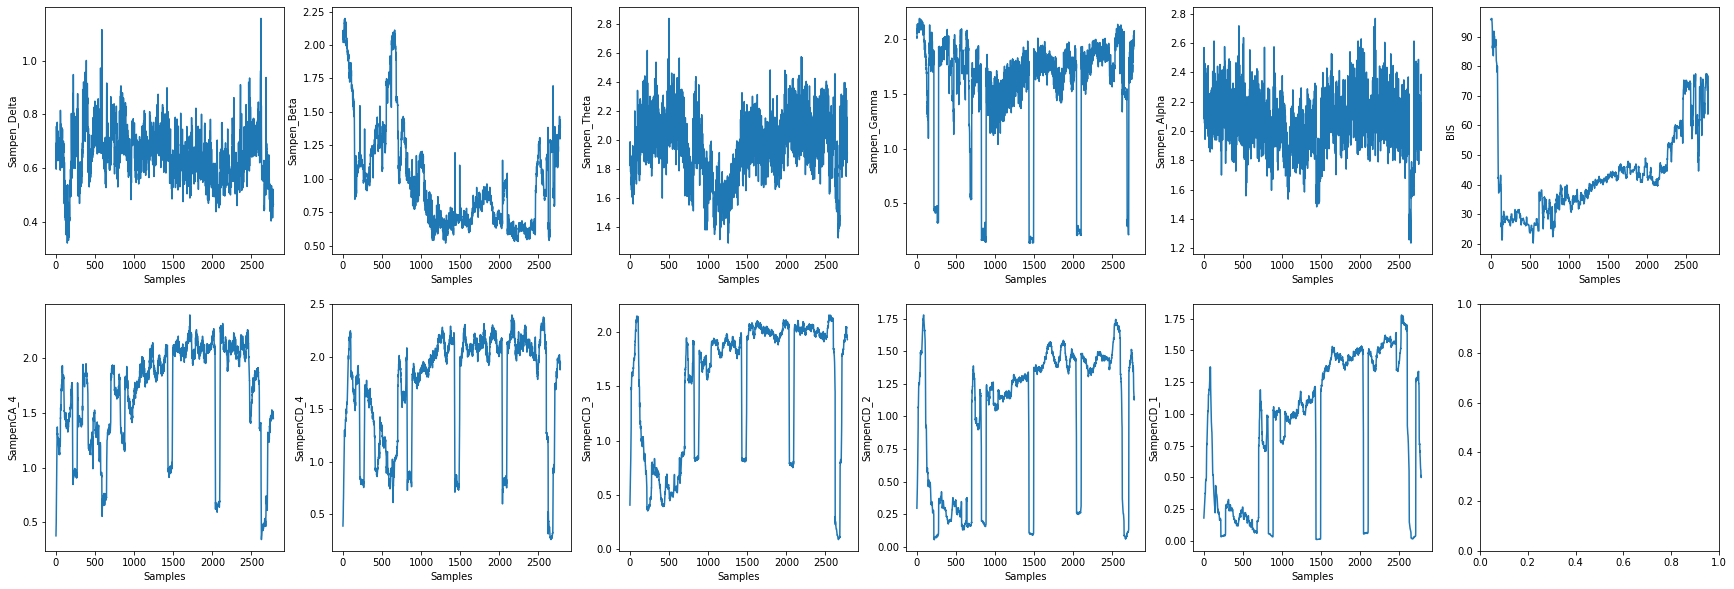

---


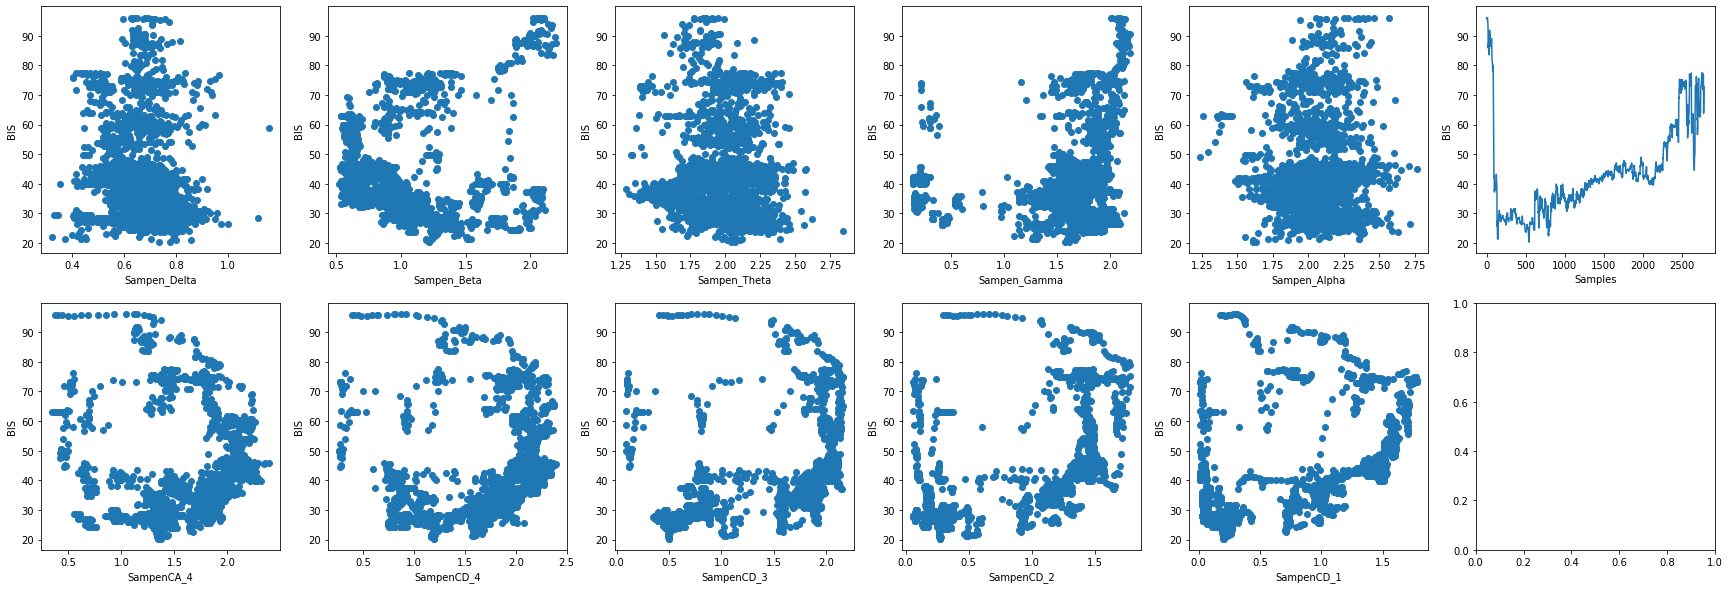



File: 14_EEG200906220903.mat


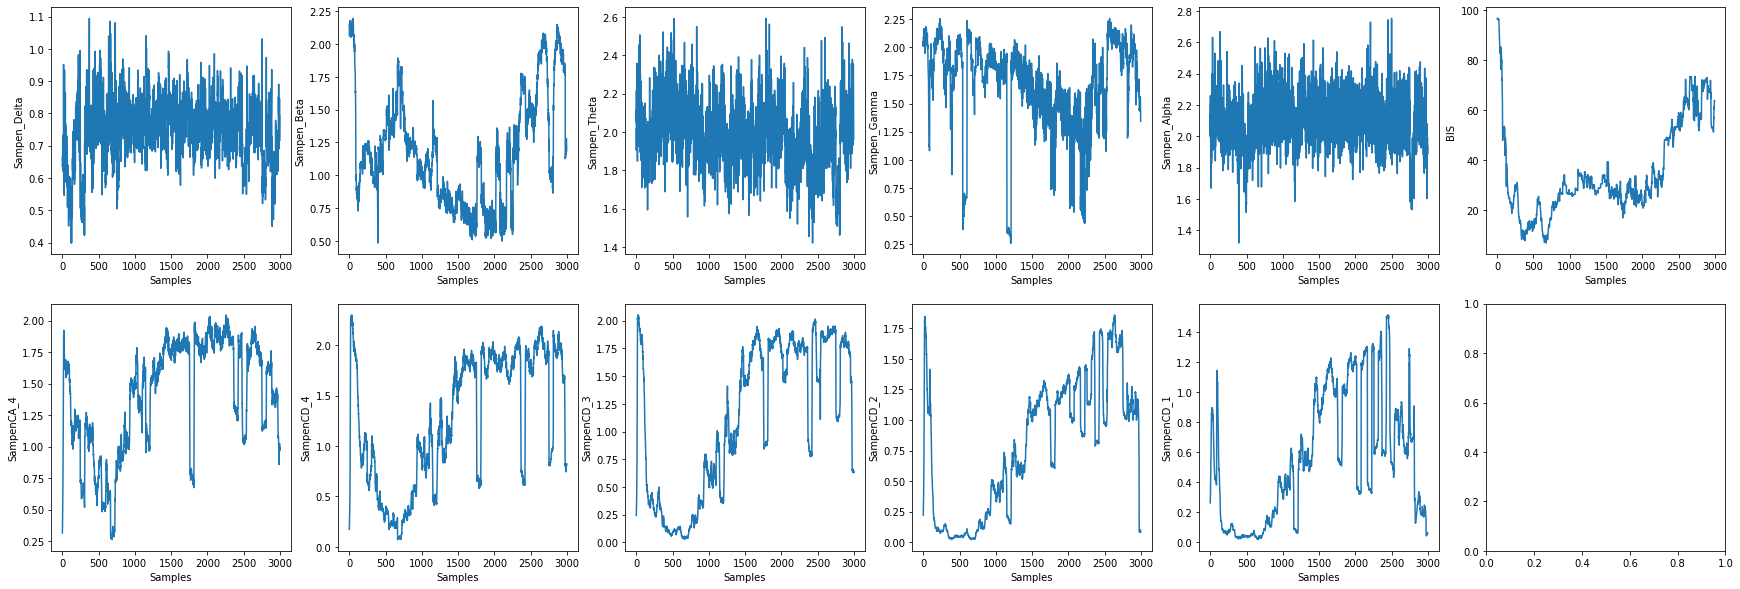

---


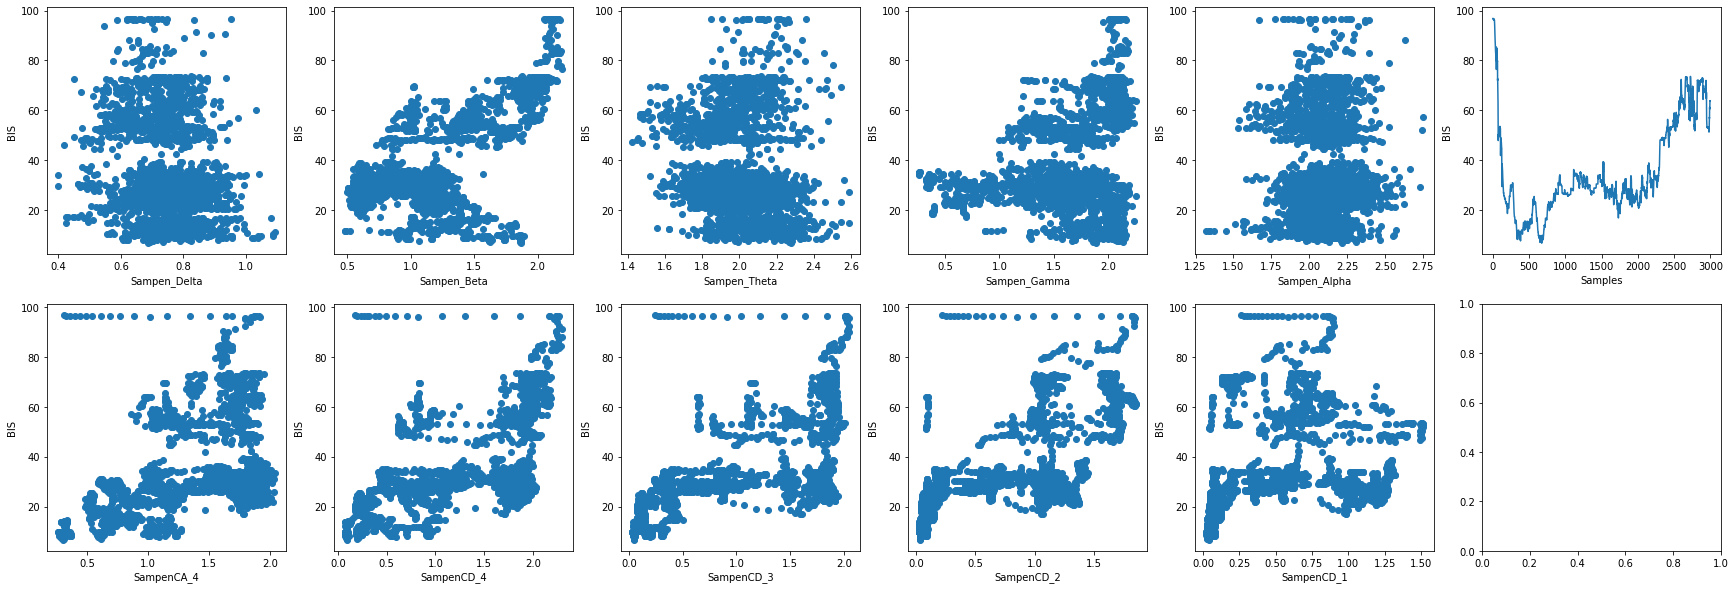



File: 4_EEG200909160908.mat


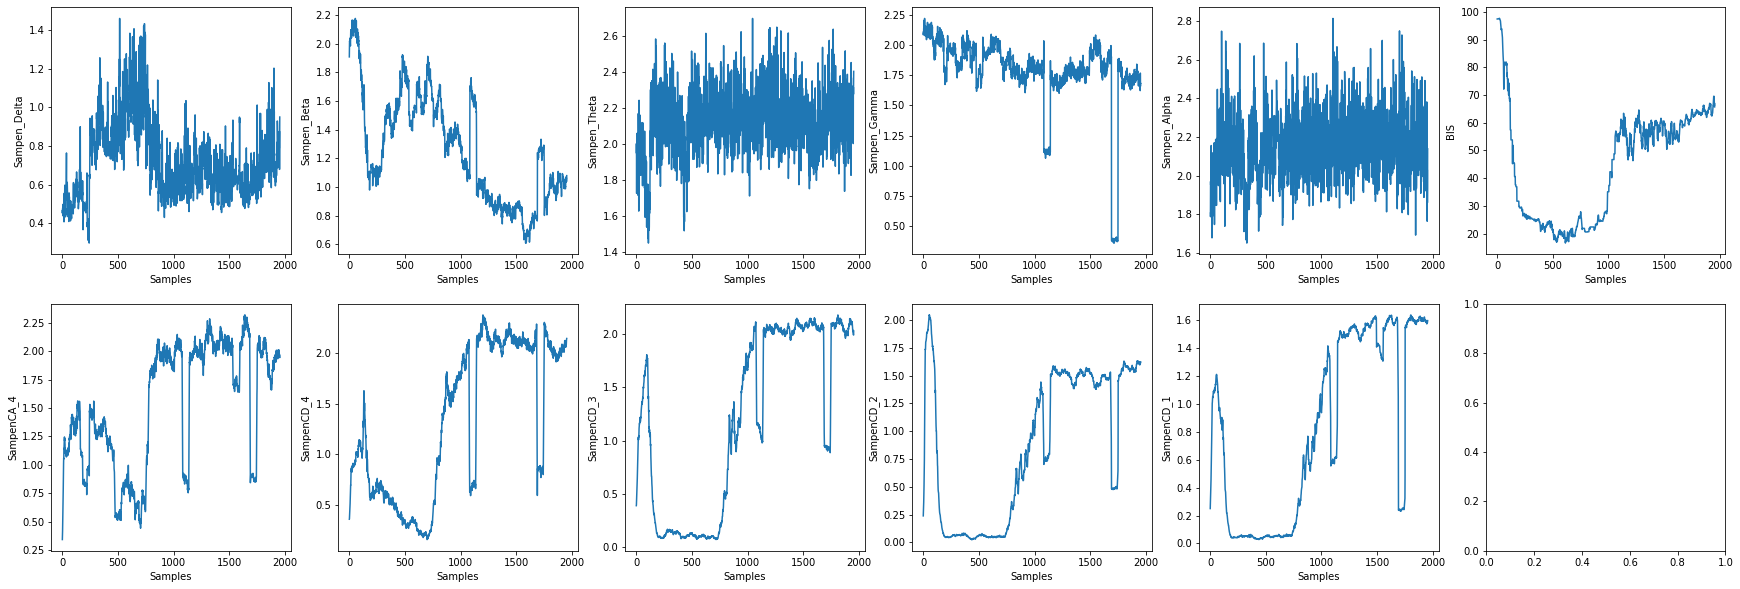

---


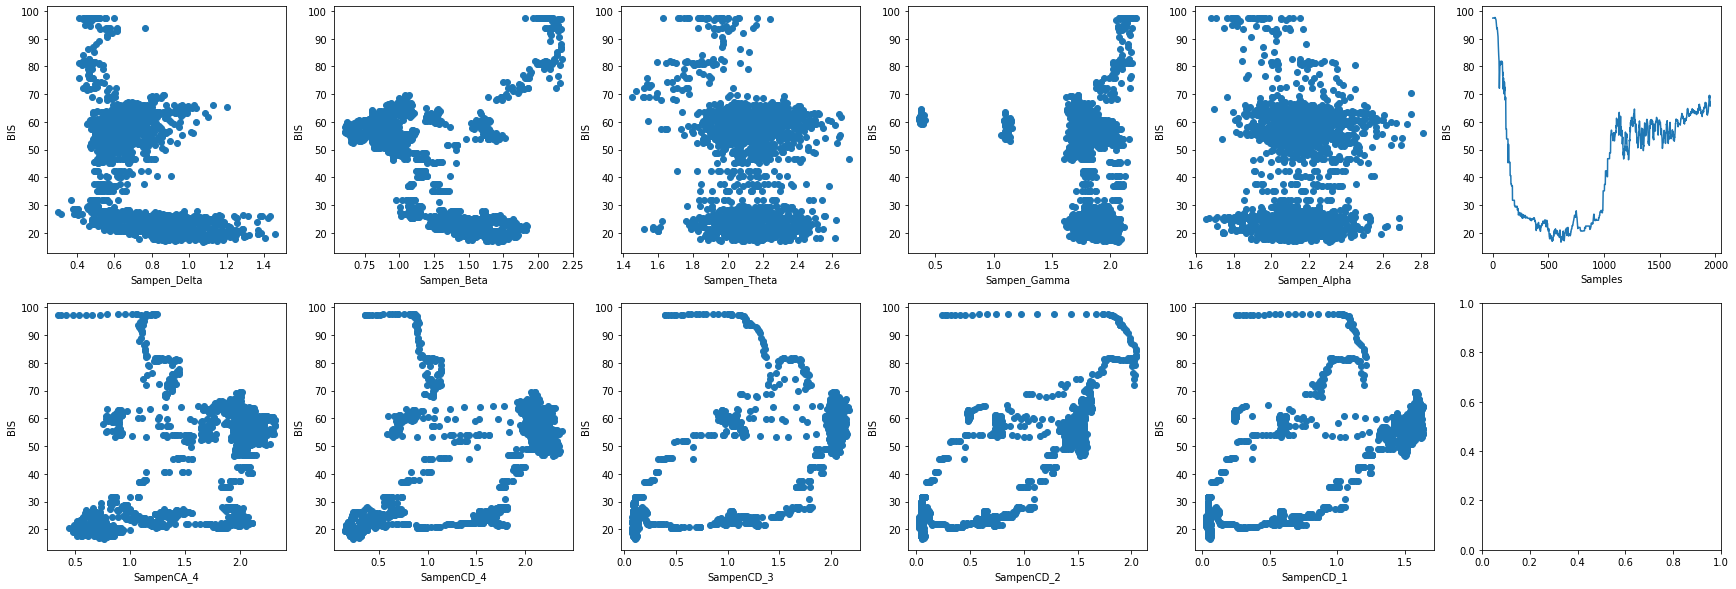



File: 13_EEG20100609.mat
Saving dataset for future use

Making relevant graphs for Patient 13_EEG20100609.mat
-------------------------------------------------------


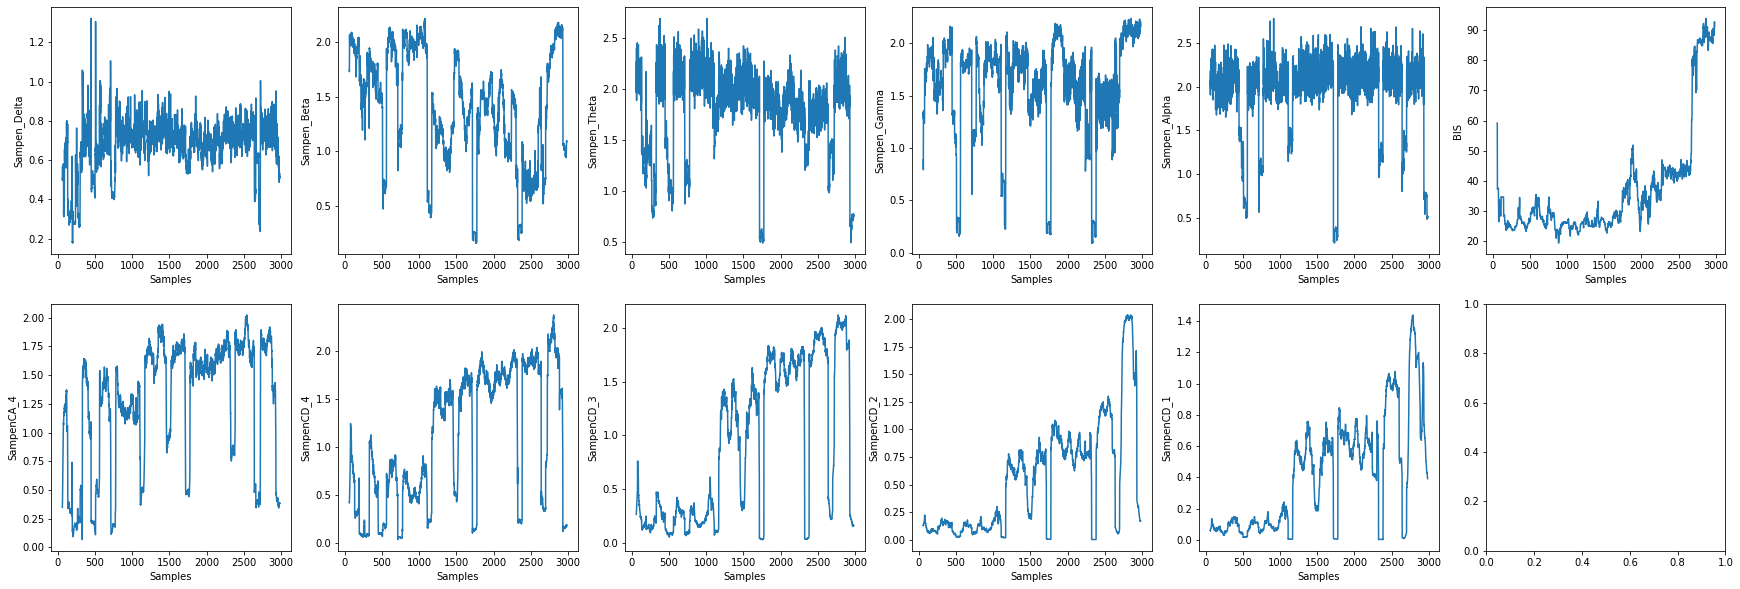

---


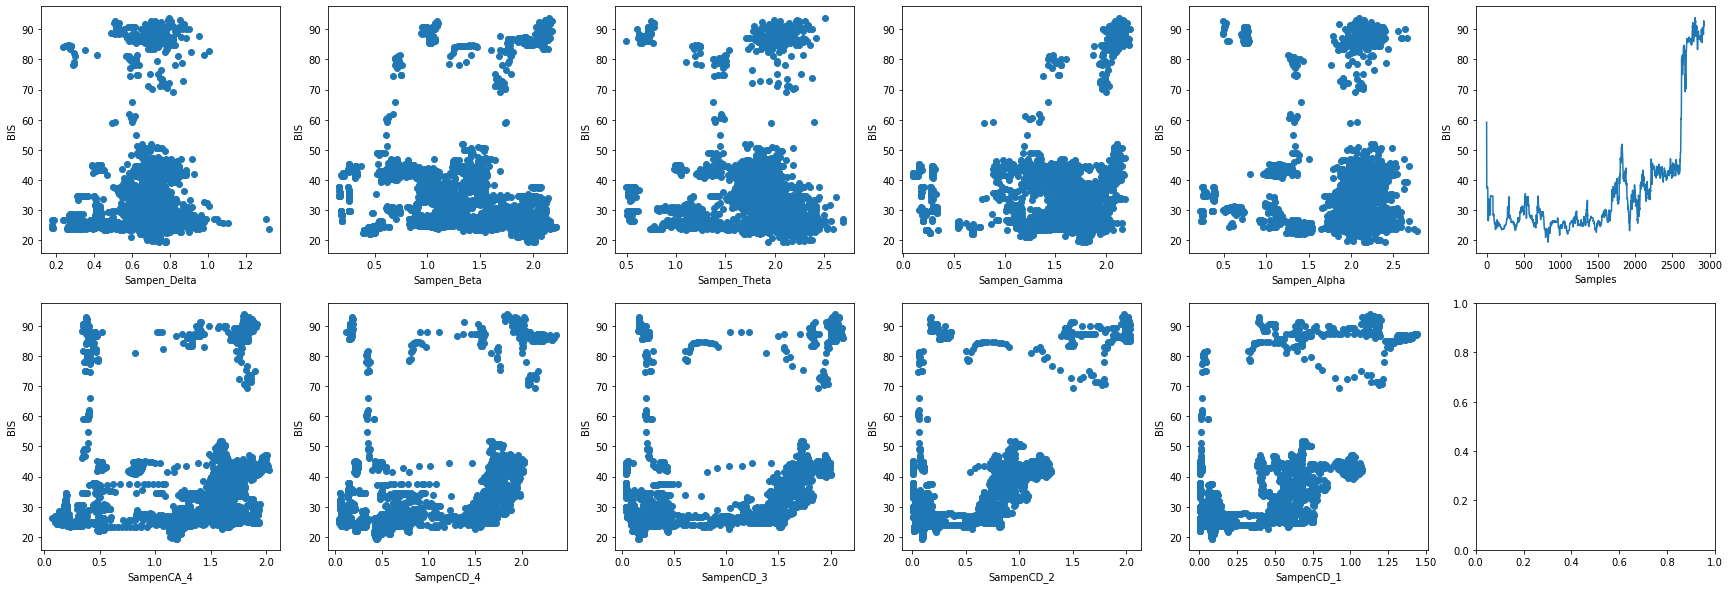



File: 19_EEG201004072.mat
Saving dataset for future use

Making relevant graphs for Patient 19_EEG201004072.mat
-------------------------------------------------------


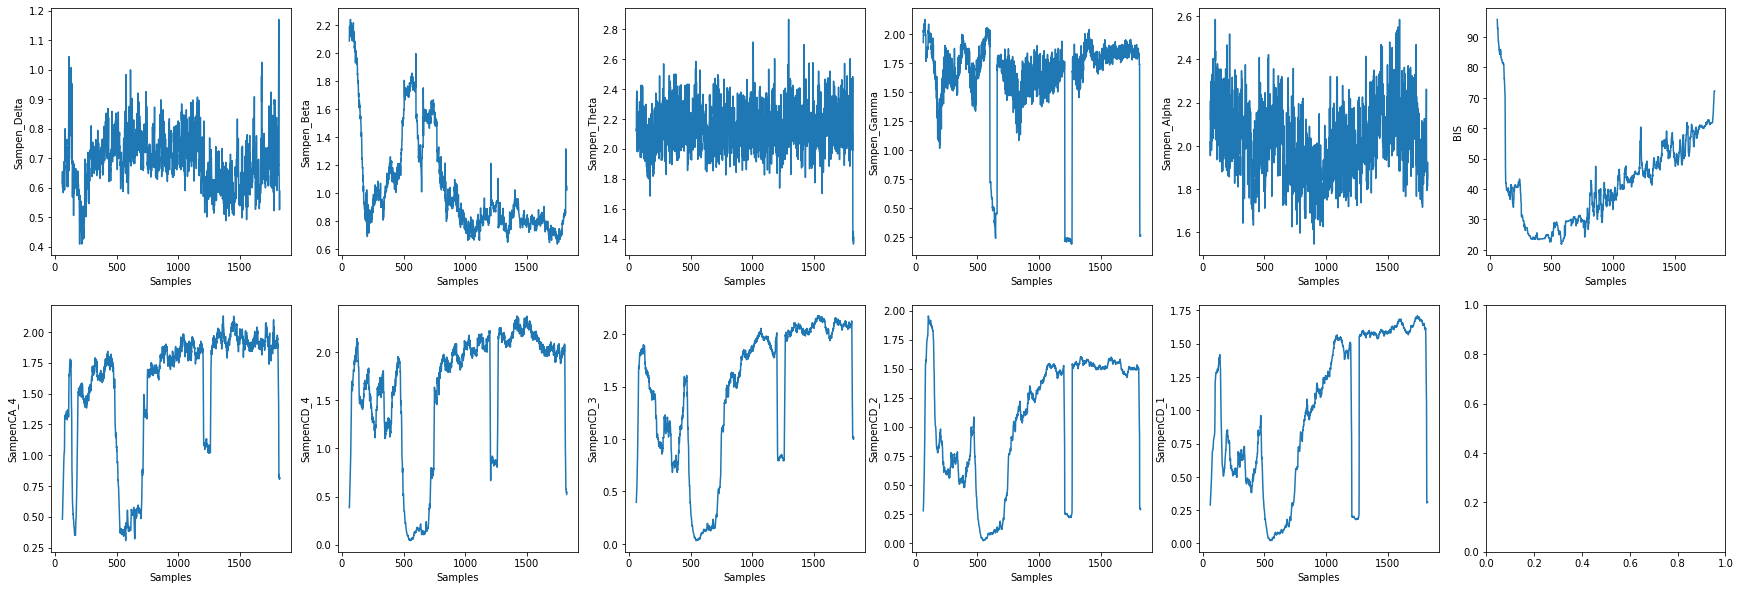

---


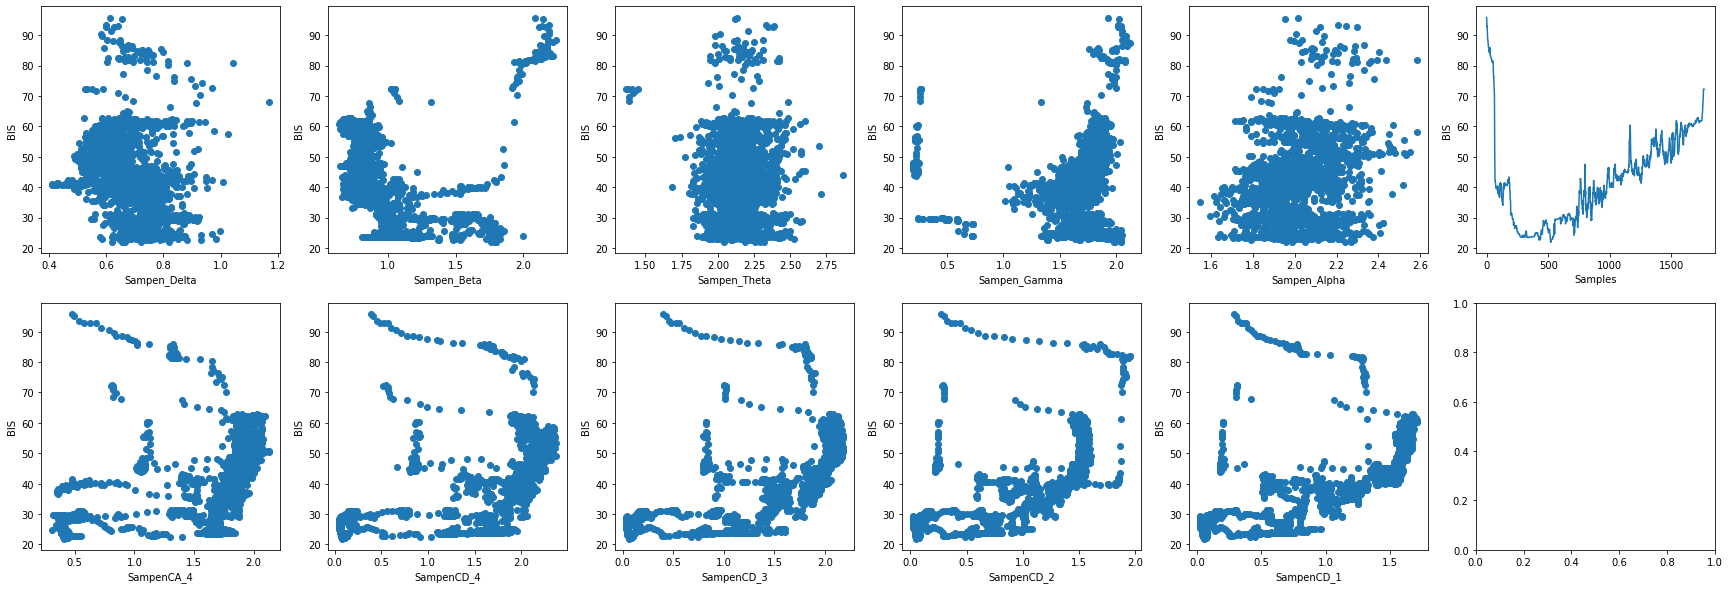



File: 30_EEG200909091.mat
Saving dataset for future use

Making relevant graphs for Patient 30_EEG200909091.mat
-------------------------------------------------------


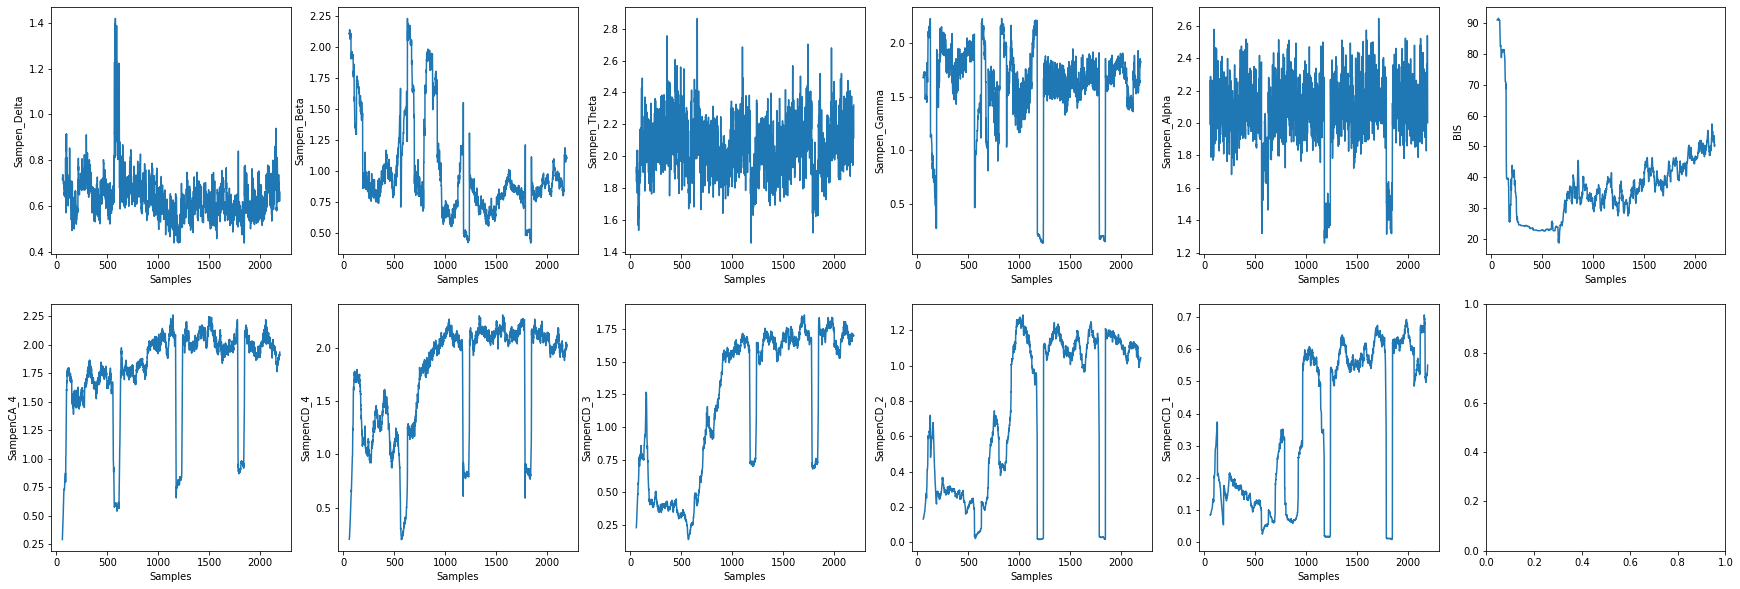

---


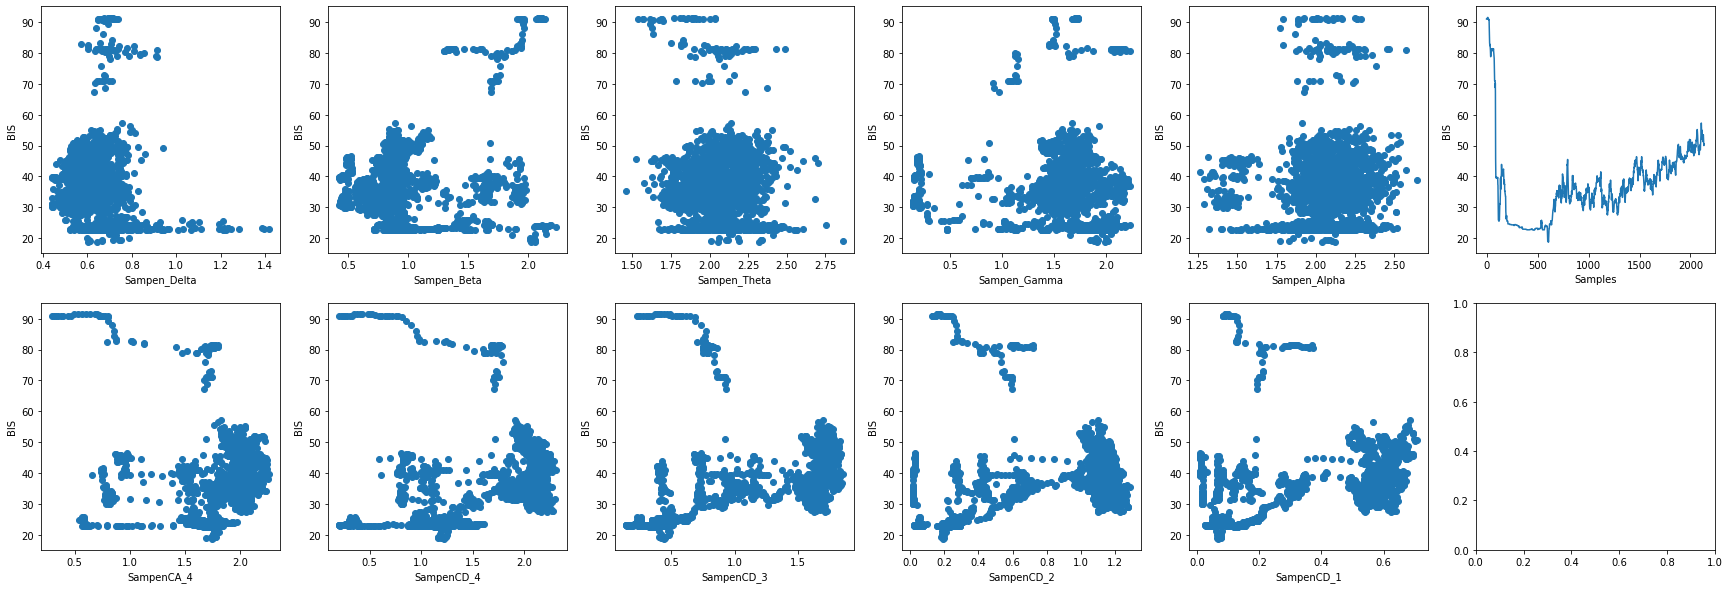



File: 2_EEG200908190811.mat
Saving dataset for future use

Making relevant graphs for Patient 2_EEG200908190811.mat
-------------------------------------------------------


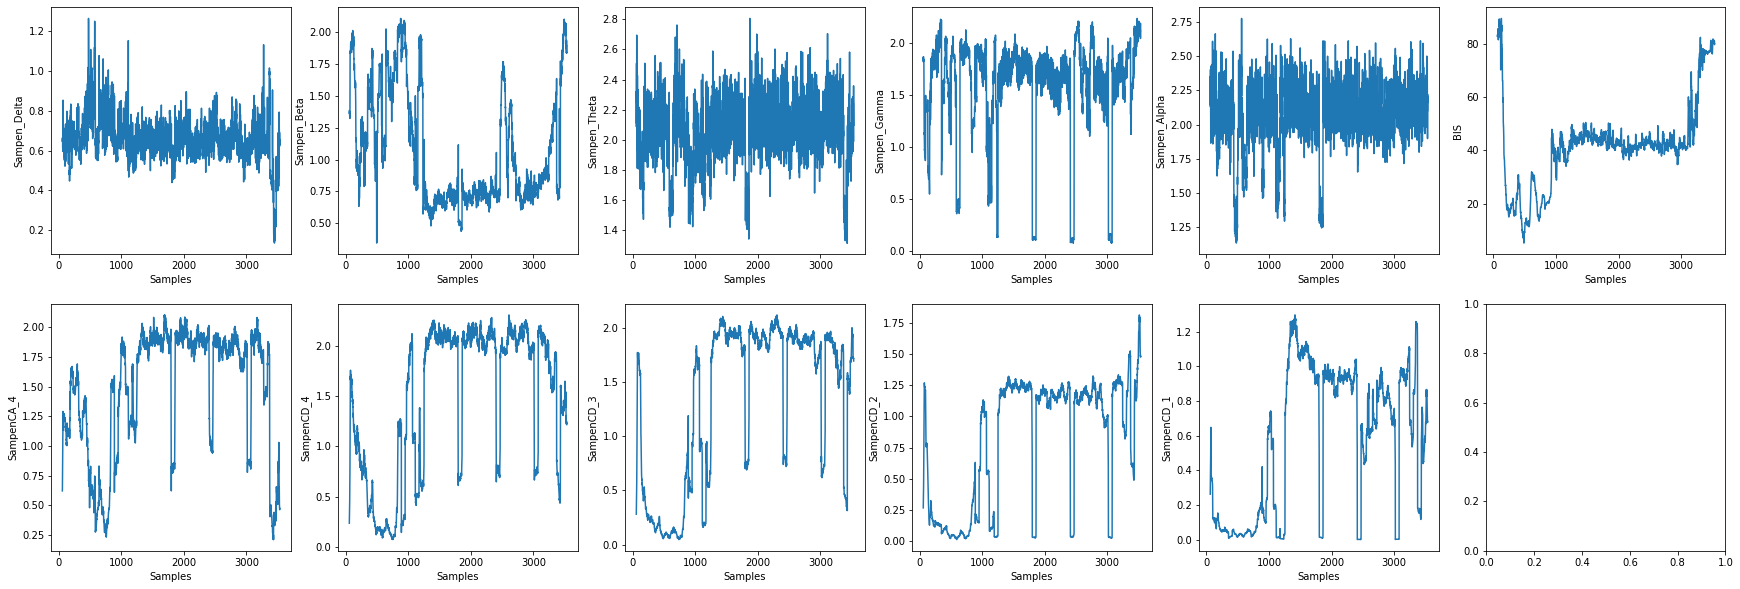

---


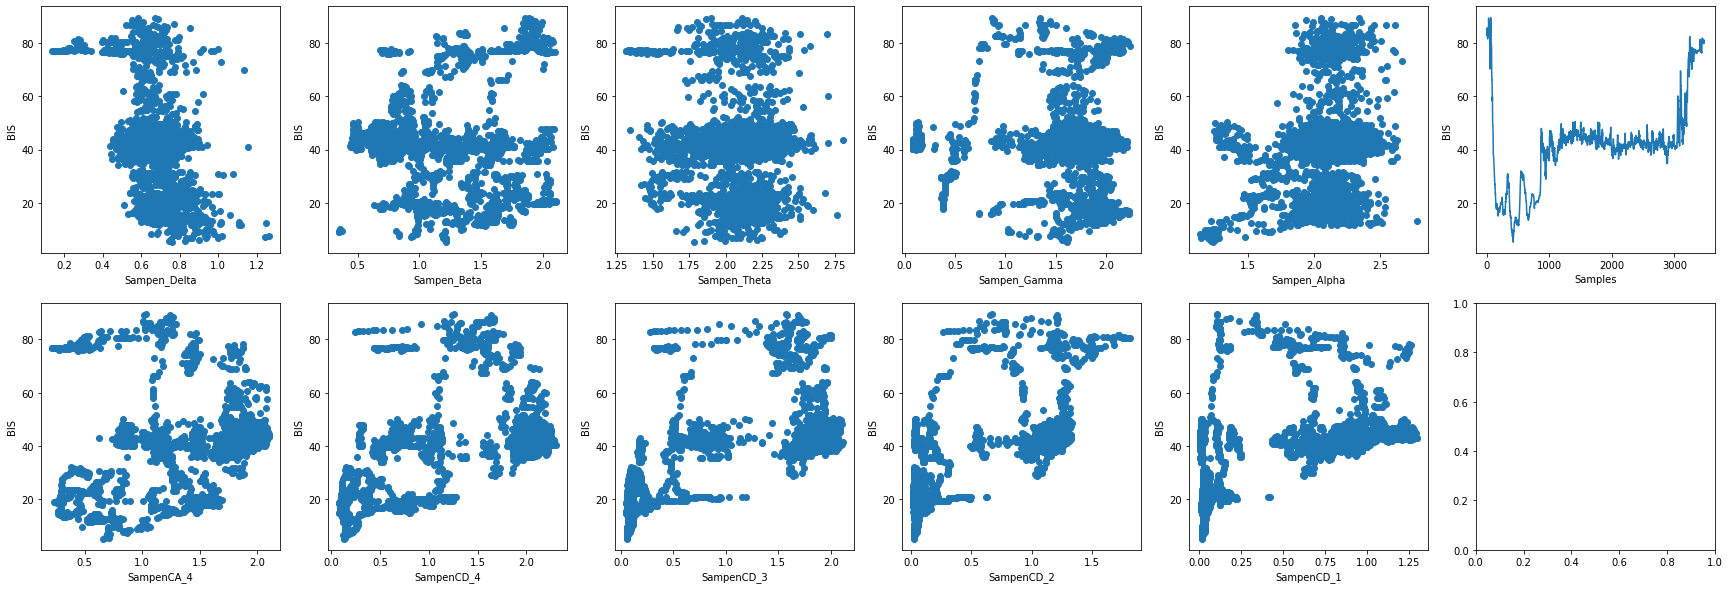



File: 32_EEG201004071.mat
Saving dataset for future use

Making relevant graphs for Patient 32_EEG201004071.mat
-------------------------------------------------------


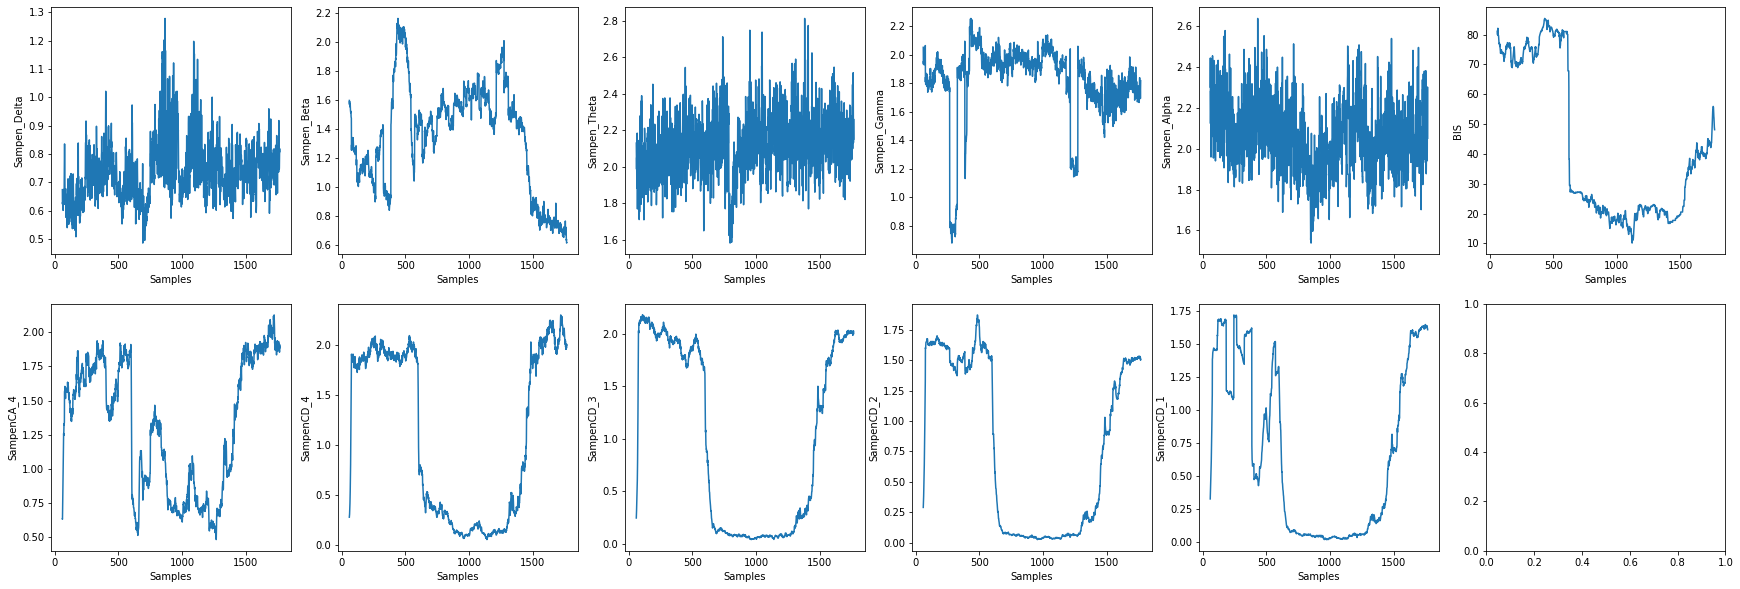

---


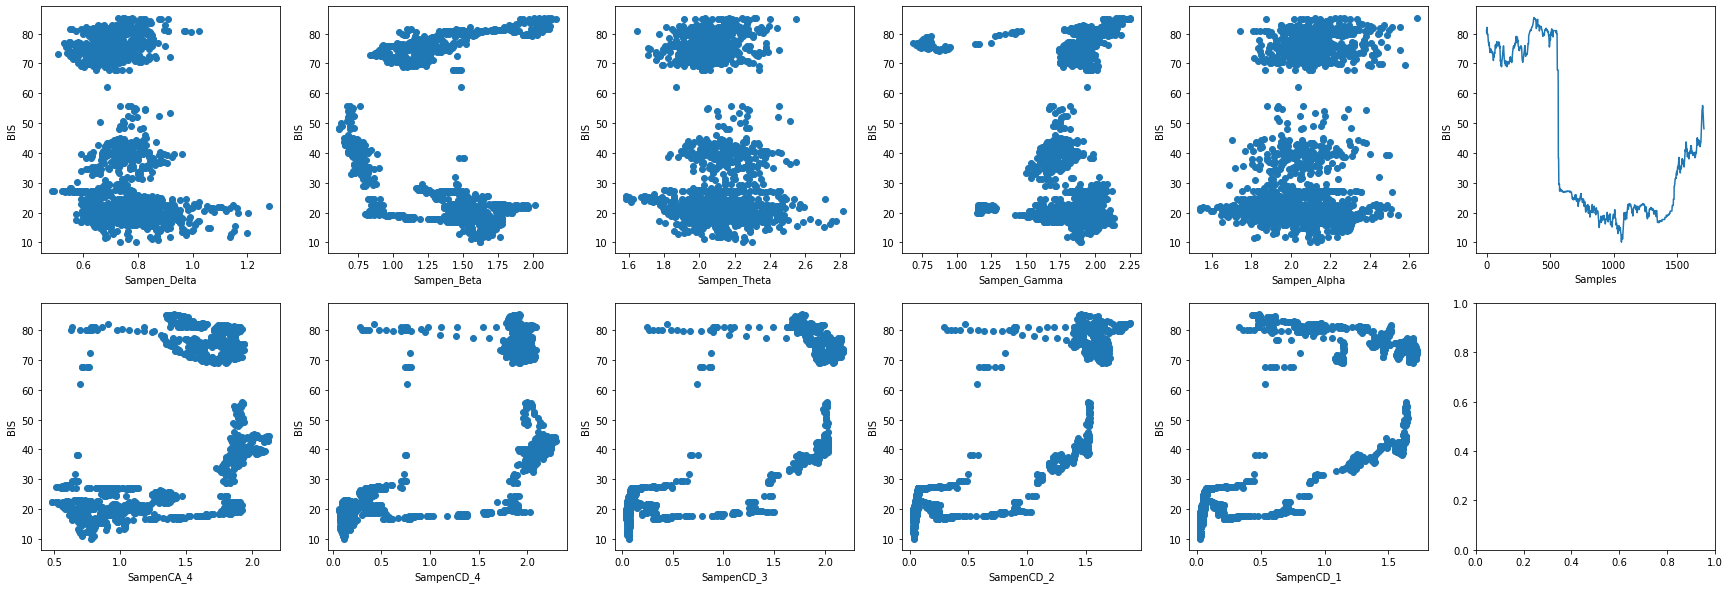



File: 20_EEG201005241.mat
Saving dataset for future use

Making relevant graphs for Patient 20_EEG201005241.mat
-------------------------------------------------------


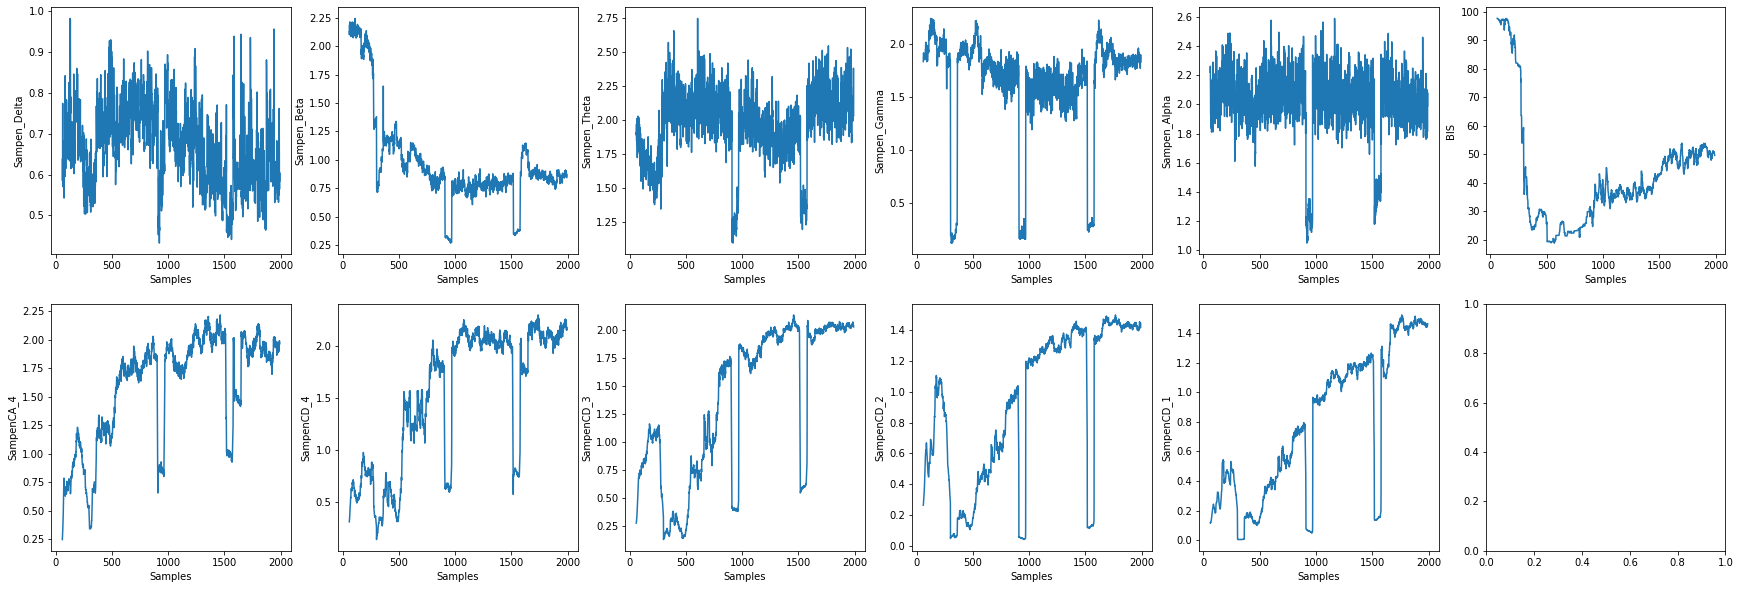

---


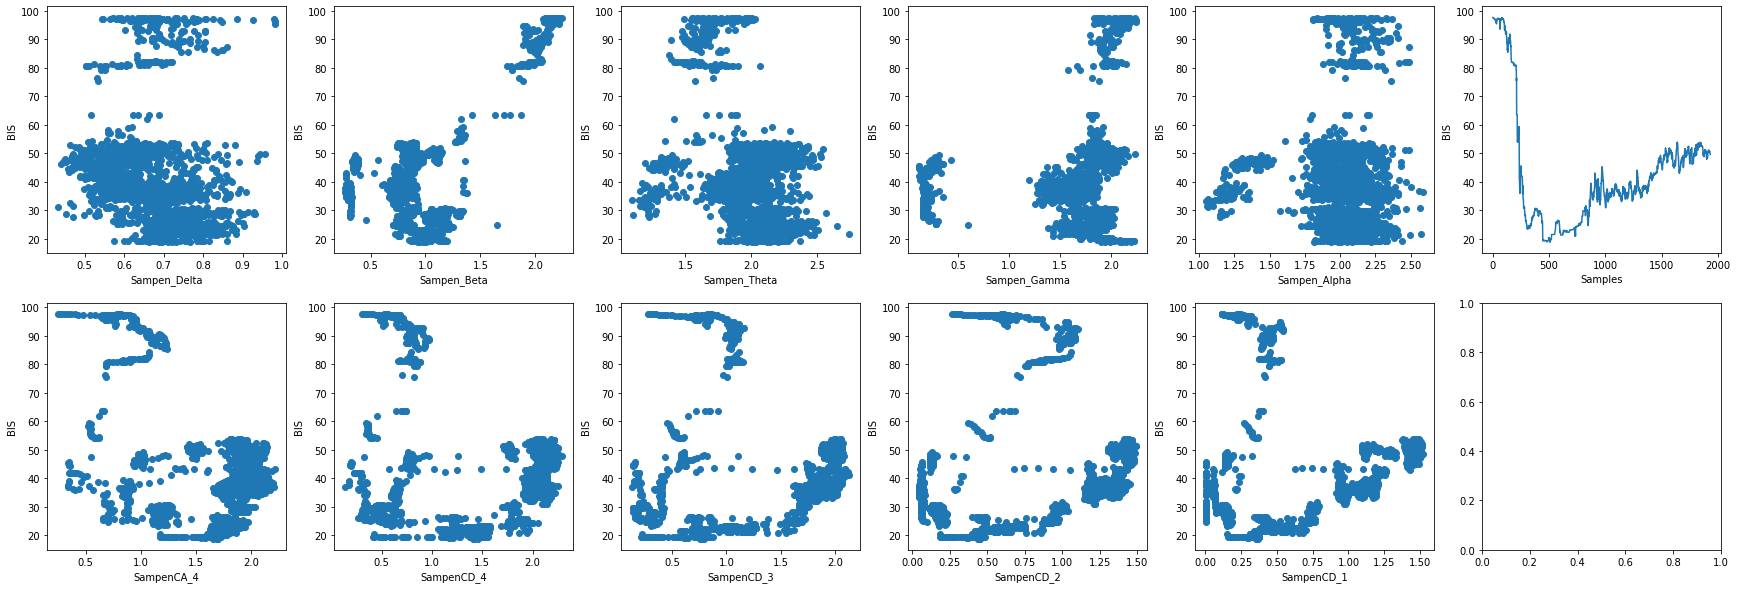



File: 7_EEG201005241657.mat
Saving dataset for future use

Making relevant graphs for Patient 7_EEG201005241657.mat
-------------------------------------------------------


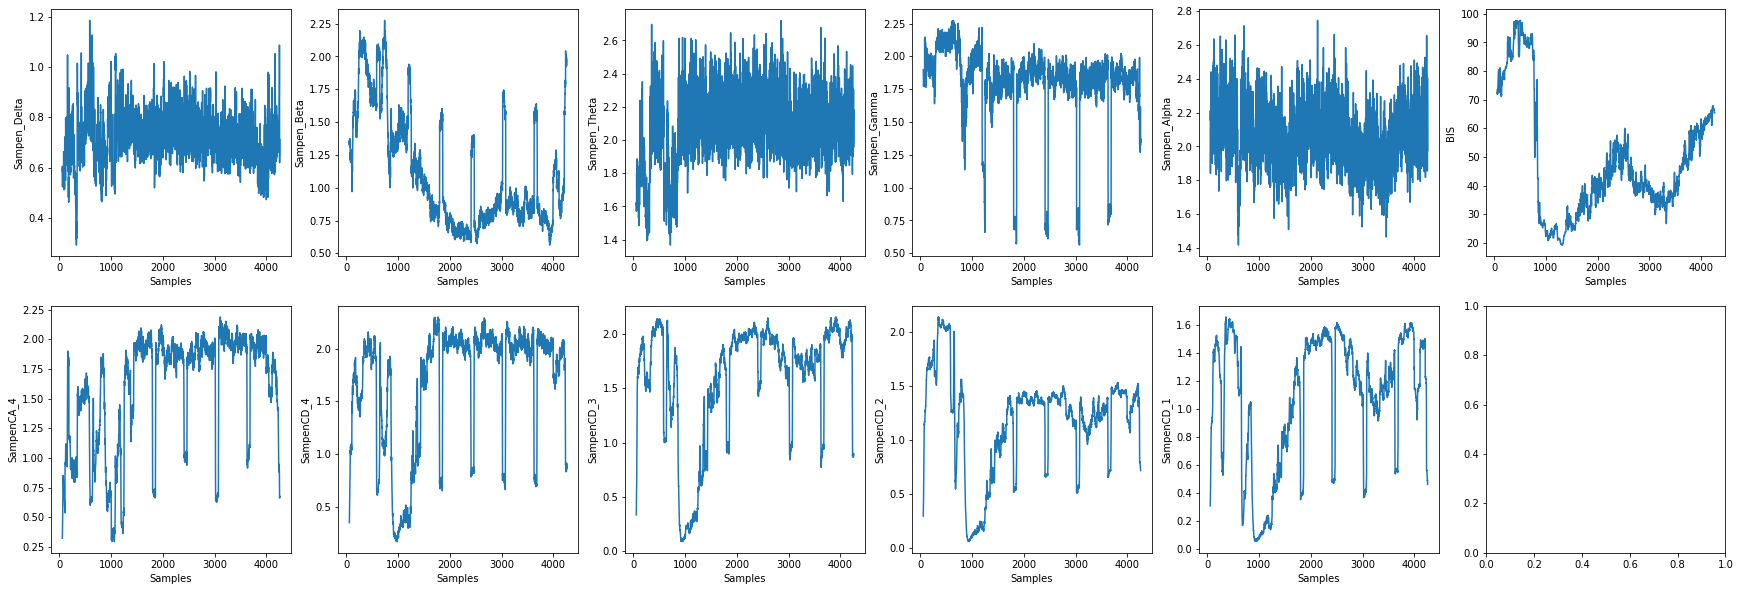

---


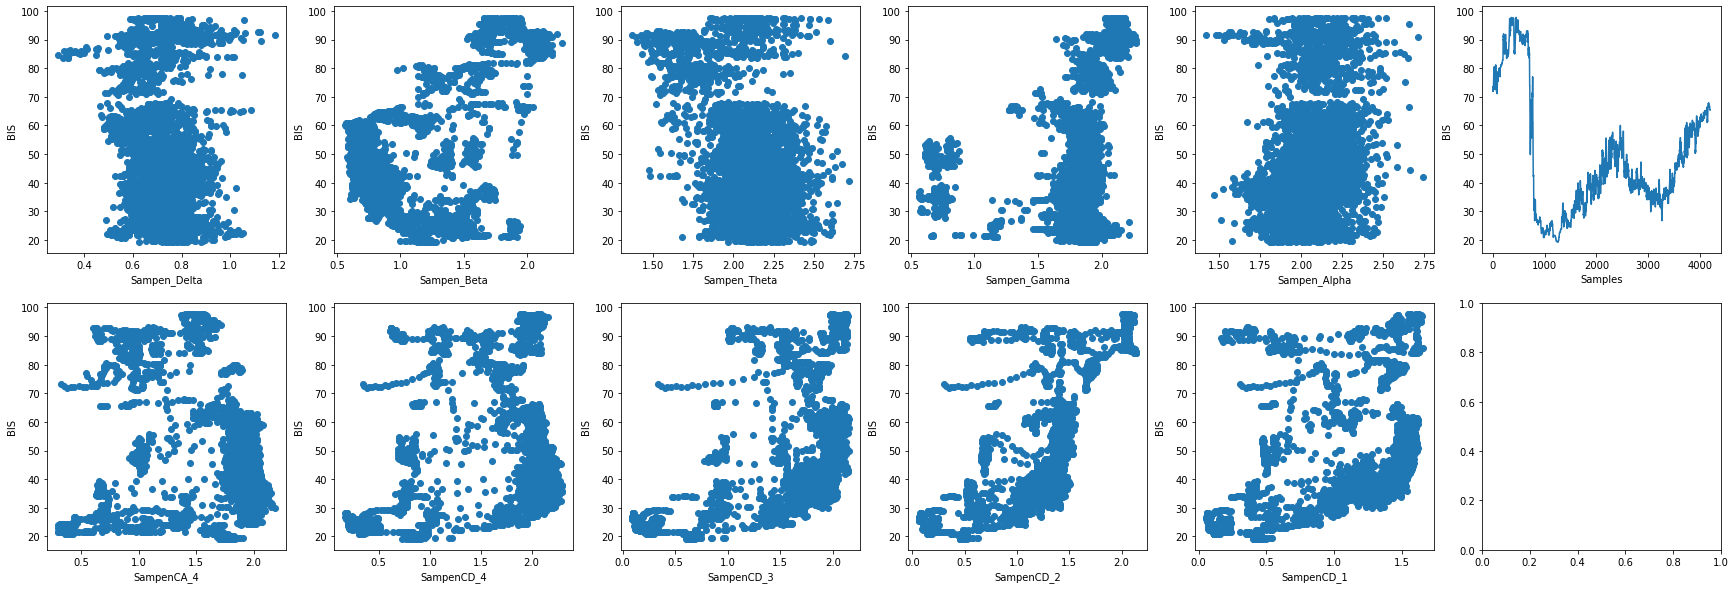



File: 3_EEG200908190921.mat
Saving dataset for future use

Making relevant graphs for Patient 3_EEG200908190921.mat
-------------------------------------------------------


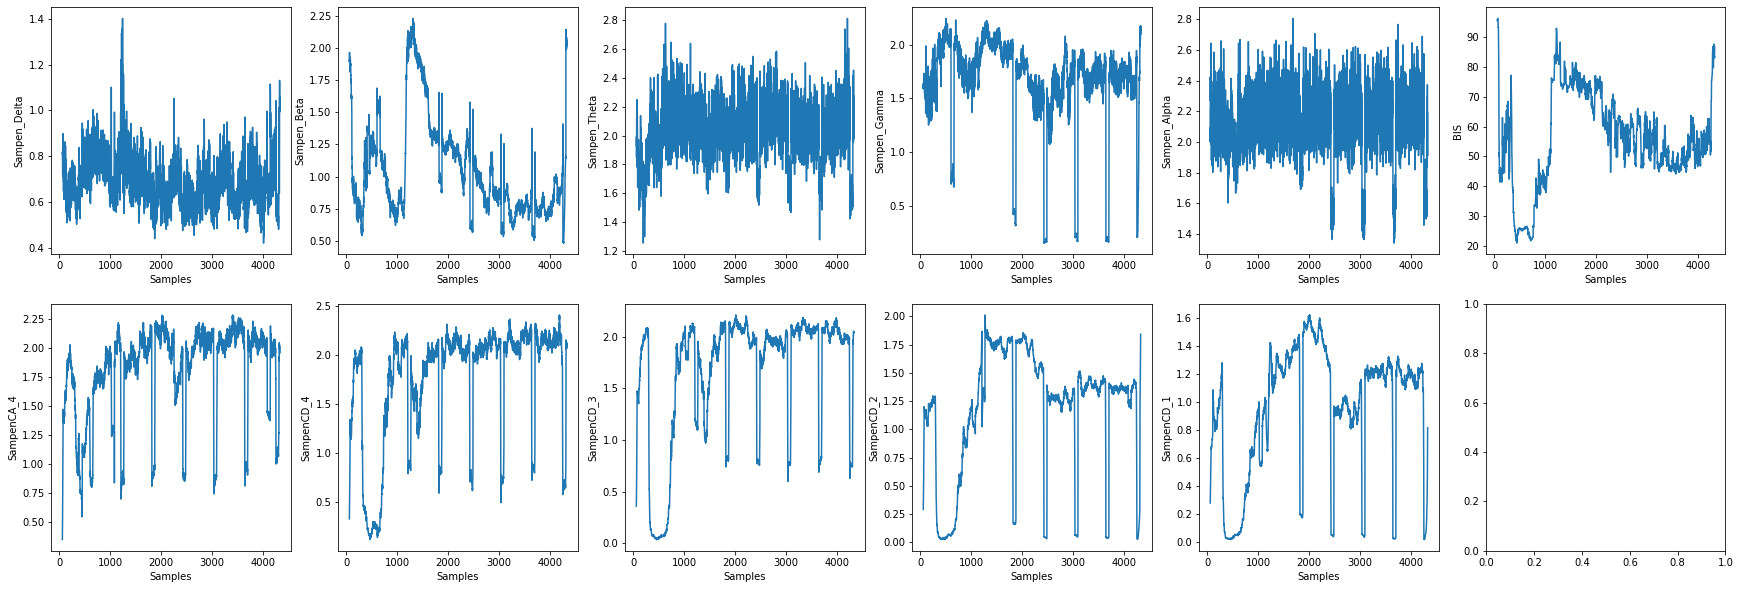

---


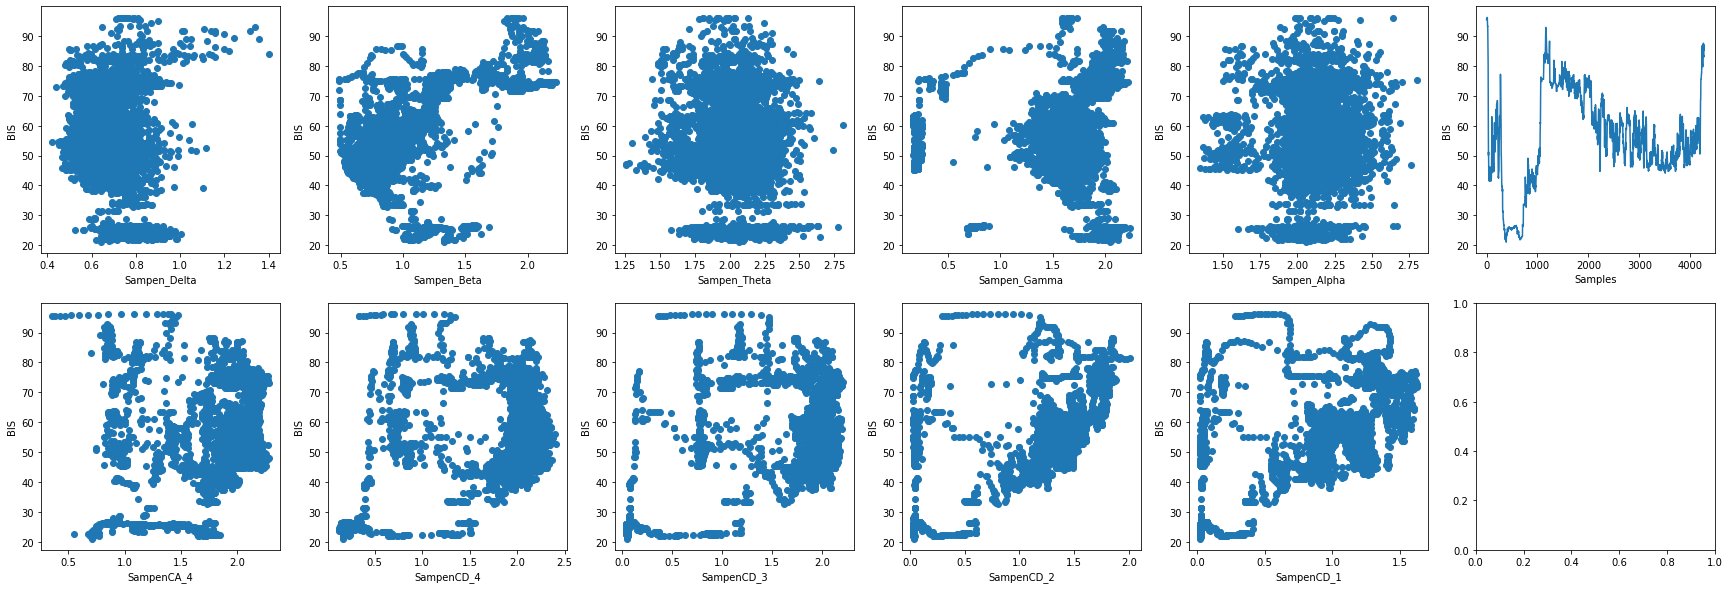

In [225]:
## Visualisations for all patients
for patient in training_set:
    print("File: {}".format(patient))
    visualise_params(patient)
    print("---")
    visualise_params(patient, 'scatter')
    print()
    print()